In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import scAR

import warnings
warnings.simplefilter("ignore")

In [3]:
from matplotlib import pylab

params = {'legend.fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (6, 4.5),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5,
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'axes.grid':False,}
pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");

In [127]:
lane2_sgRNA_raw = sc.read_10x_h5("/media/chang/HDD-1/chang/itf/lane4_scar/lane4.h5").to_df()

In [128]:
lane2_sgRNA_raw = lane2_sgRNA_raw.iloc[:,:81]

In [129]:
solo_lane2 = sc.read_10x_h5('/media/chang/HDD-1/chang/itf/lane4_scar/lane4_rna.h5')

In [130]:
solo_lane2.obs_names

Index(['AAACCCAAGAAACACT', 'AAACCCAAGAAACCAT', 'AAACCCAAGAAACCCA',
       'AAACCCAAGAAACCCG', 'AAACCCAAGAAACCTG', 'AAACCCAAGAAACGAA',
       'AAACCCAAGAAACGTC', 'AAACCCAAGAAACTAC', 'AAACCCAAGAAACTCA',
       'AAACCCAAGAAACTGC',
       ...
       'TTTGTTGTCTTTCTTC', 'TTTGTTGTCTTTGAGA', 'TTTGTTGTCTTTGATC',
       'TTTGTTGTCTTTGCAT', 'TTTGTTGTCTTTGCGC', 'TTTGTTGTCTTTGCTA',
       'TTTGTTGTCTTTGCTG', 'TTTGTTGTCTTTGGAG', 'TTTGTTGTCTTTGGCT',
       'TTTGTTGTCTTTGTCG'],
      dtype='object', length=6794880)

In [131]:
rank_UMIs = pd.DataFrame(solo_lane2[:,solo_lane2.var['feature_types']=='Gene Expression'].X.sum(axis=1), index = solo_lane2.obs_names, columns=['total_counts'])

rank_UMIs['droplets'] = 'cell-free droplets'
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>10, 'droplet II')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>500, 'droplet I')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>1500, 'cells')
rank_UMIs = rank_UMIs.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
rank_UMIs = rank_UMIs.loc[rank_UMIs['total_counts']>0]
rank_UMIs = rank_UMIs.set_index('index').rename_axis('cells')

In [86]:
rank_UMIs = pd.DataFrame(lane2_sgRNA_raw.sum(axis=1), index = solo_lane2.obs_names, columns=['total_counts'])

rank_UMIs['droplets'] = 'cell-free droplets'
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>10, 'droplet II')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>50, 'droplet I')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>100, 'cells')
rank_UMIs = rank_UMIs.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
rank_UMIs = rank_UMIs.loc[rank_UMIs['total_counts']>0]
rank_UMIs = rank_UMIs.set_index('index').rename_axis('cells')

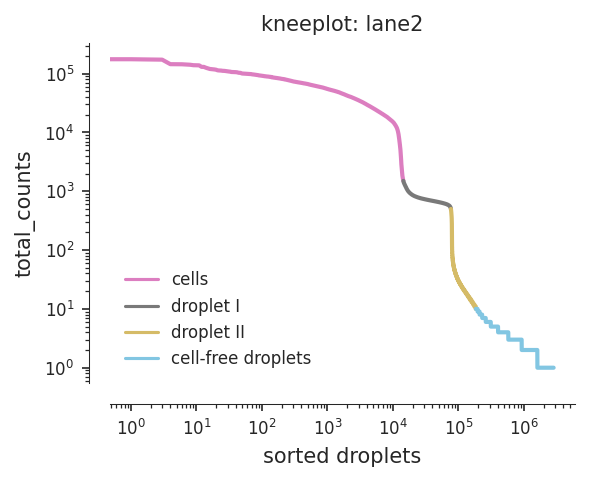

In [132]:
plt.figure(figsize=(4, 3), dpi=150)

ax = sns.lineplot(data = rank_UMIs,
                  x='rank',
                  y='total_counts',
                  hue='droplets',
                  hue_order=['cells', 'droplet I', 'droplet II', 'cell-free droplets'],
                  palette=sns.color_palette()[-4:],
                  markers=False,
                  lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets');
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot: lane2');

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

In [133]:
lane2_filtered = solo_lane2[solo_lane2.obs_names.isin(rank_UMIs[rank_UMIs['droplets']=='cells'].index)] # equal to filtered population as cellranger output
lane2_sgRNAs_filtered = lane2_sgRNA_raw[lane2_sgRNA_raw.index.isin(lane2_filtered.obs_names)] # pandas.DataFrame

In [134]:
lane2_sgRNAs_filtered

,AARS_i1,AARS_i2,ATP1A1_i1,ATP1A1_i2,AURKB_i1,AURKB_i2,CDC25B_i1,CDC25B_i2,CDK12_i1,CDK12_i,...,TRAPPC3_i1,TRAPPC3_i2,TRIM24_i1,TRIM24_i2,ZMYND8_i1,ZMYND8_i2,NTC_i1,NTC_i2,NTC_i3,NTC_i4
GATTTCTAGGATACCG,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,3.0,2.0,1.0,3.0,1.0,1.0,1.0,0.0
TCATGAGCACAAATAG,2.0,1.0,9.0,15.0,3.0,4.0,16.0,14.0,9.0,10.0,...,15.0,6.0,23.0,24.0,31.0,23.0,21.0,12.0,28.0,27.0
TCGATTTTCAGCCTCT,0.0,0.0,2.0,4.0,1.0,0.0,3.0,5.0,1.0,0.0,...,4.0,1.0,4.0,7.0,6.0,5.0,5.0,1.0,7.0,5.0
GCATCGGTCGCTTACC,1.0,1.0,0.0,3.0,0.0,0.0,4.0,5.0,4.0,2.0,...,3.0,3.0,5.0,6.0,5.0,6.0,7.0,2.0,10.0,5.0
GAAACCTGTCCGACGT,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,2.0,3.0,4.0,1.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCCATTTCACCGGGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAACCTCAGTCTGTAC,0.0,0.0,3.0,3.0,2.0,2.0,6.0,5.0,2.0,2.0,...,1.0,1.0,5.0,5.0,6.0,3.0,4.0,2.0,4.0,6.0
AGATCCAAGAAGGTAG,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
TTCCTAAAGATGTTAG,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


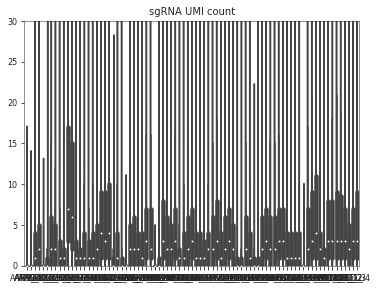

In [135]:
fig, ax = plt.subplots()
# Create a plot
sns.violinplot(data=lane2_sgRNAs_filtered)
# Add title
ax.set_title('sgRNA UMI count')
ax.set_ylim(bottom=0, top=30)
plt.show()

In [136]:
lane2_empty_droplets_sgRNAs = lane2_sgRNA_raw.loc[lane2_sgRNA_raw.index.difference(lane2_sgRNAs_filtered.index)]
lane2_empty_profile_sgRNAs = lane2_empty_droplets_sgRNAs.sum()/lane2_empty_droplets_sgRNAs.sum().sum()    # pandas.Series

In [137]:
lane2_empty_profile_sgRNAs.values.shape

(81,)

In [ ]:
scarObj_lane2 = scAR.model(raw_count=lane2_sgRNAs_filtered,
                     empty_profile=lane2_empty_profile_sgRNAs.values, # In the case of default None, the empty_profile will be calculated by averaging pooled cells
                     scRNAseq_tech='CROPseq')

scarObj_lane2.train(epochs=400)

..Running VAE using the following param set:
......scAR mode:  CROPseq
......count model:  binomial
......num_input_feature:  81
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
  2%|▏         | 6/400 [00:13<15:07,  2.30s/it]

In [ ]:
scarObj_lane2.inference(feature_type='sgRNAs', cutoff=3)

In [ ]:
scarObj_lane2.feature_assignment.sgRNAs.value_counts().head(50)

In [ ]:
scarObj_lane2.feature_assignment.sgRNAs.isnull().sum()

In [ ]:
scarObj_lane2.feature_assignment.sgRNAs

In [126]:
scarObj_lane2.feature_assignment.to_csv("/media/chang/HDD-1/chang/itf/lane4.csv")